In [1]:
import math
import tensorflow as tf
from tensorflow.python.layers.core import Dense
import numpy as np
tf.__version__

/DevTools/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


'1.4.0'

In [2]:
class Seq2Seq(object):
    def __init__(self, vocab_size, embedding_size, num_units, num_layers, out_keep_prob, batch_size, encoder_size, decoder_size, start_of_sequence_id, end_of_sequence_id, pad_of_sequence_id, learning_rate=0.0001, use_attention=False):
        print('Init new model')
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_units = num_units
        self.num_layers = num_layers
        self.out_keep_prob = out_keep_prob
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.time_major = True
        self.use_attention = use_attention
        self.global_step = tf.Variable(0, trainable=False)
        self.counter = tf.Variable(0, name='counter')
        
        self.encoder_size = encoder_size
        self.decoder_size = decoder_size
        self.start_of_sequence_id = start_of_sequence_id
        self.end_of_sequence_id = end_of_sequence_id
        self.pad_of_sequence_id = pad_of_sequence_id
        
        
    def createCell(self, num_units, num_layers):
        #return tf.contrib.rnn.BasicLSTMCell(num_units)
        cells = []
        for _ in range(self.num_layers):
            cell = tf.contrib.rnn.LSTMCell(self.num_units)  # Or LSTMCell(num_units)
            cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=self.out_keep_prob)
            cells.append(cell)
        stacked_cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)
        return stacked_cell
    
    
    def build(self):
        self._init_placeholders()
        self._init_embeddings()
        #self._init_encoder()
        self._init_bidirectional_encoder()
        self._init_decoder()
        self._init_optimizer()
        self.saver = tf.train.Saver(tf.global_variables())
        
        
    def _init_placeholders(self):
        self.encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
        self.decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
        self.decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')
        
        self.source_sequence_length = tf.placeholder(tf.int32, (None,), name='source_sequence_length')
        self.target_sequence_length = tf.placeholder(tf.int32, (None,), name='target_sequence_length')
        
        self.max_target_sequence_length = tf.reduce_max(self.target_sequence_length, name='max_target_length')
        
        
    def _init_embeddings(self):
        with tf.variable_scope("embedding") as scope:
            # Uniform(-sqrt(3), sqrt(3)) has variance=1.
            sqrt3 = math.sqrt(3)
            initializer = tf.random_uniform_initializer(-sqrt3, sqrt3)
            
            self.embedding_matrix = tf.get_variable(
                                        name="embedding_matrix",
                                        shape=[self.vocab_size, self.embedding_size],
                                        initializer=initializer,
                                        dtype=tf.float32
                                    )
            
            self.embeddings = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0), dtype=tf.float32)
            self.encoder_inputs_embedded = tf.nn.embedding_lookup(self.embedding_matrix, self.encoder_inputs)
            self.decoder_inputs_embedded = tf.nn.embedding_lookup(self.embedding_matrix, self.decoder_inputs)
            
            #self.encoder_inputs_embedded = tf.contrib.layers.embed_sequence(self.encoder_inputs, self.vocab_size, self.embedding_size)
            #self.embedding_matrix = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size]))
            #self.decoder_inputs_embedded = tf.nn.embedding_lookup(self.embedding_matrix, self.decoder_inputs)
    
    
    def _init_encoder(self):
        with tf.variable_scope("encoder") as scope:
            self.encoder_cell = self.createCell(self.num_units, self.num_layers)
            self.encoder_outputs, self.encoder_state = tf.nn.dynamic_rnn(
                                                                        cell=self.encoder_cell,
                                                                        inputs=self.encoder_inputs_embedded,
                                                                        dtype=tf.float32,
                                                                        sequence_length=self.source_sequence_length,
                                                                        time_major=self.time_major
                                                                    )
    
    
    def _init_bidirectional_encoder(self):
        with tf.variable_scope("bidirectional_encoder") as scope:
            num_bi_layers = int(self.num_layers / 2)
            self.encoder_cell_fw = self.createCell(self.num_units, num_bi_layers)
            self.encoder_cell_bw = self.createCell(self.num_units, num_bi_layers)
            
            encoder_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
                                                                cell_fw=self.encoder_cell_fw,
                                                                cell_bw=self.encoder_cell_bw,
                                                                inputs=self.encoder_inputs_embedded,
                                                                dtype=tf.float32,
                                                                sequence_length=self.source_sequence_length,
                                                                time_major=self.time_major,
                                                                swap_memory=True
                                                            )
            #self.encoder_outputs = tf.concat(outputs, -1)
            #self.encoder_state = states
            #if num_bi_layers == 1:
            #    self.encoder_state = bi_encoder_state
            #else:
            # alternatively concat forward and backward states
            self.encoder_state = []
            for layer_id in range(num_bi_layers):
                self.encoder_state.append(bi_encoder_state[0][layer_id])  # forward
                self.encoder_state.append(bi_encoder_state[1][layer_id])  # backward
            self.encoder_state = tuple(self.encoder_state)
                
            self.encoder_outputs = tf.concat(encoder_outputs, -1)
            
            
    def _init_decoder(self):

        output_layer = Dense(self.vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
        
        with tf.variable_scope("decoder") as scope:
            
            if self.use_attention:
                #attention_states: [batch_size, max_time, num_units] (not time_major)
                if self.time_major:
                    attention_states = tf.transpose(self.encoder_outputs, [1, 0, 2])
                else:
                    attention_states = self.encoder_outputs

                # Create an attention mechanism
                attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                                    num_units=self.num_units, memory=attention_states,
                                    memory_sequence_length=self.source_sequence_length)
                
                stacked_cell = self.createCell(self.num_units, self.num_layers)
                #attention_cell= tf.contrib.rnn.BasicLSTMCell(self.num_units)
                attention_cell = tf.contrib.seq2seq.AttentionWrapper(
                                                                    cell=stacked_cell,
                                                                    attention_mechanism=attention_mechanism,
                                                                    attention_layer_size=self.num_units,  # don't add an additional dense layer.
                                                                    output_attention=False)
                #self.decoder_cell= GNMTAttentionMultiCell(attention_cell, cells)
                
                self.decoder_cell = attention_cell

                initial_state = self.decoder_cell.zero_state(self.batch_size, tf.float32).clone(cell_state=self.encoder_state)
                #initial_state = self.decoder_cell.zero_state(dtype=tf.float32, batch_size=self.batch_size)
            else:
                self.decoder_cell = self.createCell(self.num_units, self.num_layers)
                initial_state =self.encoder_state
            
            # Helper for the training process. Used by BasicDecoder to read inputs.
            training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=self.decoder_inputs_embedded,
                                                                sequence_length=self.target_sequence_length,
                                                                time_major=self.time_major)


            # Basic decoder
            training_decoder = tf.contrib.seq2seq.BasicDecoder(cell=self.decoder_cell,
                                                               helper=training_helper,
                                                               initial_state=initial_state,
                                                               output_layer=output_layer) 

            # Perform dynamic decoding using the decoder
            self.decoder_outputs, self.decoder_state, self.final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(decoder=training_decoder,
                                                                           impute_finished=True,
                                                                           output_time_major=self.time_major,
                                                                           maximum_iterations=self.max_target_sequence_length)
        
            # Inference
            start_tokens = tf.tile(tf.constant([self.start_of_sequence_id], dtype=tf.int32), [self.batch_size], name='start_tokens')

            # Helper for the inference process.
            inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(self.embedding_matrix,
                                                                    start_tokens,
                                                                    self.end_of_sequence_id)

            # Basic decoder
            inference_decoder = tf.contrib.seq2seq.BasicDecoder(cell=self.decoder_cell,
                                                            helper=inference_helper,
                                                            initial_state=initial_state,
                                                            output_layer=output_layer)

            # Perform dynamic decoding using the decoder
            self.inference_output, _, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                                impute_finished=True,
                                                                output_time_major=self.time_major,
                                                                maximum_iterations=self.max_target_sequence_length)
            
            self.training_logits = tf.identity(self.decoder_outputs.rnn_output, 'logits')
            self.inference_logits = tf.identity(self.inference_output.sample_id, name='predictions')
        
     
    def _init_optimizer(self):
        max_gradient_norm = 5.0
        # Create the weights for sequence_loss
        self.masks = tf.sequence_mask(self.target_sequence_length, self.max_target_sequence_length, dtype=tf.float32, name='masks')

        with tf.name_scope("optimization"):
            # Loss function
            self.train_loss = tf.contrib.seq2seq.sequence_loss(
                self.training_logits,
                self.decoder_targets,
                self.masks)
            
            # Calculate and clip gradients
            params = tf.trainable_variables()
            gradients = tf.gradients(self.train_loss, params)
            clipped_gradients, _ = tf.clip_by_global_norm(gradients, max_gradient_norm)
        
            # Optimizer
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.train_optimizer = optimizer.apply_gradients(zip(clipped_gradients, params), global_step=self.global_step)
    
    
    def training(self, session, batch_encoder_input, batch_decoder_input, batch_decoder_target):
        input_feed = self.preprocessData(batch_encoder_input, batch_decoder_input, batch_decoder_target)
        output_feed = [self.train_optimizer, self.train_loss]
        outputs = session.run(output_feed, input_feed)
        return outputs[0], outputs[1]
    
    
    def inference(self, session, batch_encoder_input, batch_decoder_input, batch_decoder_target):
        input_feed = self.preprocessData(batch_encoder_input, batch_decoder_input, batch_decoder_target)
        predict = session.run(self.inference_logits, input_feed)
        if self.time_major:
            return predict.T
        else:
            return predict
    
    
    def preprocessData(self, batchX, batchY, batchZ):
        input_feed = {}
        
        if self.time_major:
            input_feed[self.encoder_inputs.name] = batchX.T
            input_feed[self.decoder_inputs.name] = batchY.T
            input_feed[self.decoder_targets.name] = batchZ.T
        else:
            input_feed[self.encoder_inputs.name] = batchX
            input_feed[self.decoder_inputs.name] = batchY
            input_feed[self.decoder_targets.name] = batchZ
        
        pad_targets_lengths = []
        for target in batchY:
            pad_targets_lengths.append(len(target))
            #pad_targets_lengths.append(len(target)-list(target).count(0))

        pad_source_lengths = []
        for source in batchX:
            #pad_source_lengths.append(len(source))
            pad_source_lengths.append(len(source)-list(source).count(0))
            
        input_feed[self.source_sequence_length.name] = pad_source_lengths
        input_feed[self.target_sequence_length.name] = pad_targets_lengths
        
        return input_feed

In [3]:
import tensorflow as tf
import numpy as np
from random import sample
import pickle
import os

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [4]:
batch_size=100
num_time_steps=5
def create_sample_data():
    x = np.random.randint(10, size=(batch_size, num_time_steps), dtype=np.int32)+1
    tmp = np.zeros((batch_size, num_time_steps), dtype=np.int32)
    for i in range(x.shape[0]):
        tmp[i] = x[i][::-1]
    
    pad = np.zeros((batch_size, 1), dtype=np.int32)
    z = np.append(tmp, pad, axis=1)
    y = np.append(pad, tmp, axis=1)
    #for i in range(x.shape[0]):
    #    y[i] = x[i][::-1]
    return x, y, z

In [5]:
x, y, z = create_sample_data()

In [6]:
def next_batch111():
    x,y,z = create_sample_data()
    
    return x, y, z

def next_batch222():
    x,y,z = create_sample_data()
    
    pad_targets_lengths = []
    for target in y:
        pad_targets_lengths.append(len(target))
    
    pad_source_lengths = []
    for source in x:
        #pad_source_lengths.append(len(source))
        pad_source_lengths.append(len(source)-list(source).count(0))
            
    return {
        model.encoder_inputs.name: x.T,
        model.decoder_inputs.name: y.T,
        model.decoder_targets.name: z.T,
        model.source_sequence_length.name: pad_source_lengths,
        model.target_sequence_length.name: pad_targets_lengths
    }

In [7]:
args = dict(vocab_size = 11,
            embedding_size = 11,
            num_units= 256,
            num_layers = 4,
            out_keep_prob = 0.75,
            learning_rate=0.01,
            encoder_size=5,
            decoder_size=6,
            start_of_sequence_id=0,
            end_of_sequence_id=0,
            pad_of_sequence_id=0,
            batch_size=batch_size,
            use_attention=True
           )
model = Seq2Seq(**args)
model.build()

Init new model


In [8]:
sess.run(tf.global_variables_initializer())
loss_track = []

In [9]:
max_batches = 500
batches_in_epoch = 50

try:
    for batch in range(max_batches):
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            
        x, y, z = next_batch111()
        _, l = model.training(sess, x, y, z)
        loss_track.append(l)
            
except KeyboardInterrupt:
    print('training interrupted')
    

batch 0
batch 50
batch 100
batch 150
batch 200
batch 250
batch 300
batch 350
batch 400
batch 450


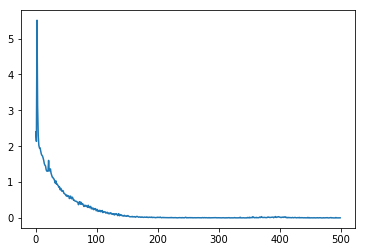

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)

In [11]:
x,y,z = next_batch111()

In [12]:
pre = model.inference(sess, x,y,z)

In [13]:
pre[0:5]

array([[ 3,  5, 10,  6,  2,  0],
       [ 6,  7, 10,  4,  2,  0],
       [ 4,  7,  2,  1,  7,  0],
       [ 7,  9,  7,  8, 10,  0],
       [ 5,  5,  7,  7,  8,  0]], dtype=int32)

In [14]:
x[0:5]

array([[ 2,  6, 10,  5,  3],
       [ 2,  4, 10,  7,  6],
       [ 7,  1,  2,  7,  4],
       [10,  8,  7,  9,  7],
       [ 8,  7,  7,  5,  5]], dtype=int32)